## Импорт библиотек

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.4 MB/s eta 0:00:00


In [ ]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    roc_curve
)
from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    train_test_split
)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

## Часть 1. PCA

### Загрузка и обработка датасета (EDA)

In [ ]:
# https://archive.ics.uci.edu/dataset/186/wine+quality

In [ ]:
file_id = "1MLJiwn2P8sMzJWLuyyjPr-u4sAQYWU2V"
URL = f"https://drive.google.com/uc?id={file_id}"
df = pd.read_csv(URL, sep=';')

print("=== ИСХОДНЫЕ ДАННЫЕ ===")
print(f"Размерность: {df.shape}")
print(f"\nТипы данных:\n{df.dtypes}")
print(f"\nПервые 5 строк:\n")
df.head()

=== ИСХОДНЫЕ ДАННЫЕ ===
Размерность: (1599, 12)

Типы данных:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Первые 5 строк:



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### 1. Проверка соответствия типов данных

In [ ]:
print("Все признаки должны быть числовыми:")
print(df.dtypes)

# Проверяем, есть ли нечисловые значения
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"\n{col}: {len(unique_vals)} уникальных значений")
    if len(unique_vals) < 15:
        print(f"  Значения: {unique_vals}")

Все признаки должны быть числовыми:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

fixed acidity: 96 уникальных значений

volatile acidity: 143 уникальных значений

citric acid: 80 уникальных значений

residual sugar: 91 уникальных значений

chlorides: 153 уникальных значений

free sulfur dioxide: 60 уникальных значений

total sulfur dioxide: 144 уникальных значений

density: 436 уникальных значений

pH: 89 уникальных значений

sulphates: 96 уникальных значений

alcohol: 65 уникальных значений

quality: 6 уникальных значений
  Значения: [5 6 7 4 8 3]


#### 2. Обработка пропущенных значений

In [ ]:
print("Пропущенные значения до обработки:")
print(df.isnull().sum())

# Заполнение пропусков медианой (если есть)
if df.isnull().sum().sum() > 0:
    df_filled = df.fillna(df.median())
    print("Пропуски заполнены медианными значениями")
else:
    df_filled = df.copy()
    print("Пропущенных значений не обнаружено")

Пропущенные значения до обработки:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Пропущенных значений не обнаружено


#### 3. Обработка дубликатов

In [ ]:
duplicates = df_filled.duplicated().sum()
print(f"Найдено дубликатов: {duplicates}")

if duplicates > 0:
    df_clean = df_filled.drop_duplicates()
    print(f"Дубликаты удалены. Новый размер: {df_clean.shape}")
else:
    df_clean = df_filled.copy()
    print("Дубликатов не обнаружено")

Найдено дубликатов: 240
Дубликаты удалены. Новый размер: (1359, 12)


#### 4. Обработка аномальных значений и выбросов

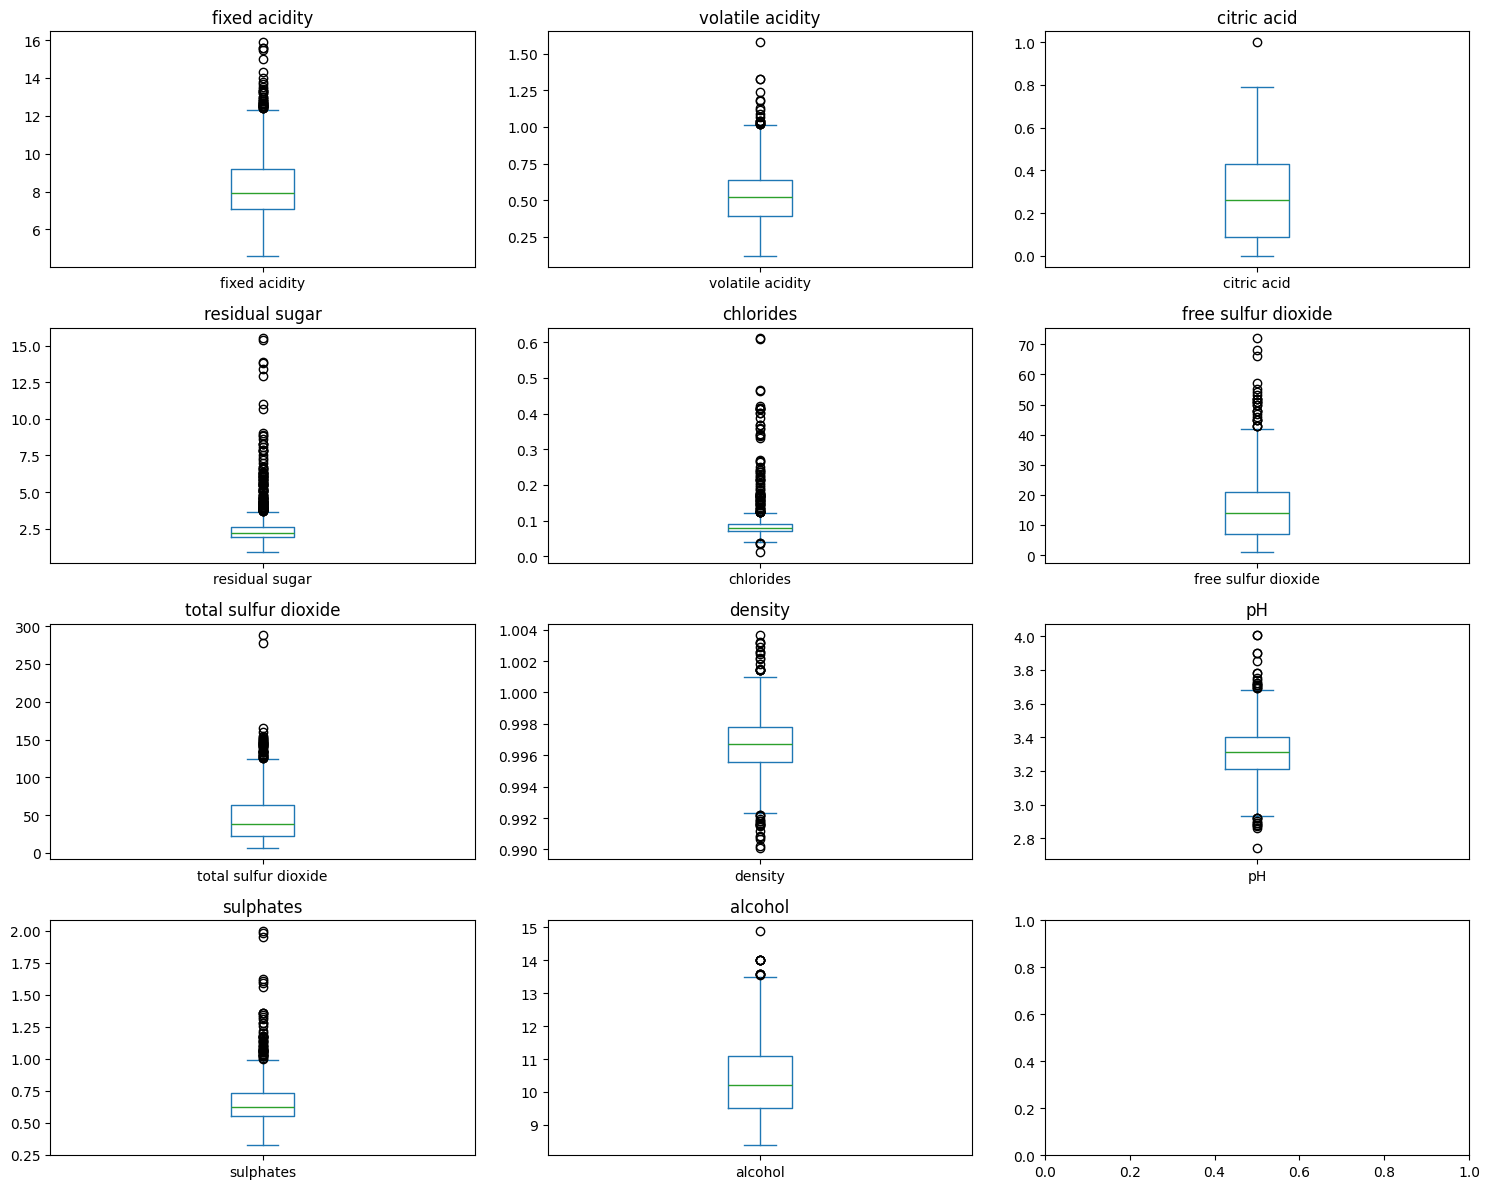

In [ ]:
# Визуализация выбросов
fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(df_clean.columns[:-1]):  # исключаем целевую переменную
    df_clean[col].plot(kind='box', ax=axes[i], title=col)
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Статистический анализ выбросов
def detect_outliers_iqr(data):
    outliers_dict = {}
    for col in data.columns[:-1]:  # исключаем quality
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outliers_dict[col] = len(outliers)
    return outliers_dict


outliers_count = detect_outliers_iqr(df_clean)
print("Количество выбросов по признакам (метод IQR):")
for col, count in outliers_count.items():
    print(f"  {col}: {count} выбросов")

# Обработка выбросов - winsorization (более мягкий метод)
df_no_outliers = df_clean.copy()
for col in df_no_outliers.columns[:-1]:
    lower_limit = df_no_outliers[col].quantile(0.01)
    upper_limit = df_no_outliers[col].quantile(0.99)
    df_no_outliers[col] = np.clip(df_no_outliers[col], lower_limit, upper_limit)

print("Выбросы обработаны методом winsorization (1-99 перцентили)")

Количество выбросов по признакам (метод IQR):
  fixed acidity: 41 выбросов
  volatile acidity: 19 выбросов
  citric acid: 1 выбросов
  residual sugar: 126 выбросов
  chlorides: 87 выбросов
  free sulfur dioxide: 26 выбросов
  total sulfur dioxide: 45 выбросов
  density: 35 выбросов
  pH: 28 выбросов
  sulphates: 55 выбросов
  alcohol: 12 выбросов
Выбросы обработаны методом winsorization (1-99 перцентили)


#### 5. Анализ распределения целевой переменной

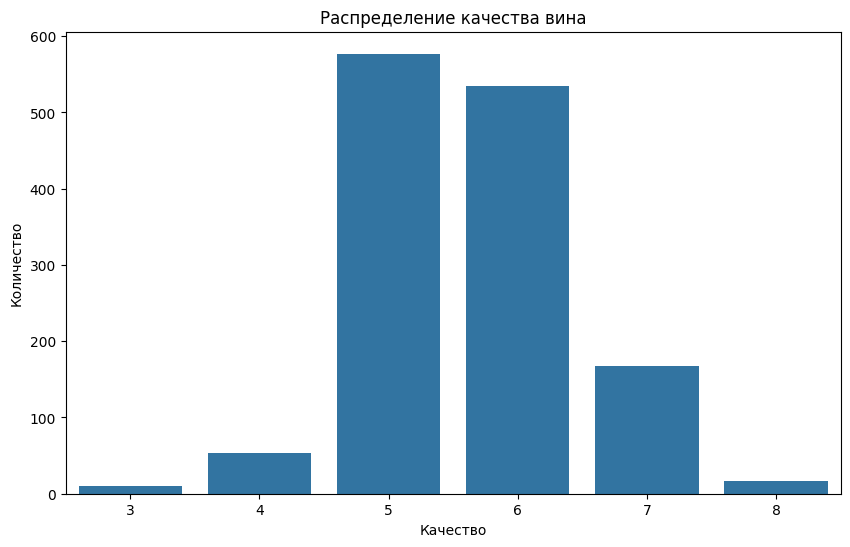

Распределение по качеству:
quality
3     10
4     53
5    577
6    535
7    167
8     17
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_no_outliers, x='quality')
plt.title('Распределение качества вина')
plt.xlabel('Качество')
plt.ylabel('Количество')
plt.show()

print("Распределение по качеству:")
print(df_no_outliers['quality'].value_counts().sort_index())

#### 6. Скалирование / Нормализация данных

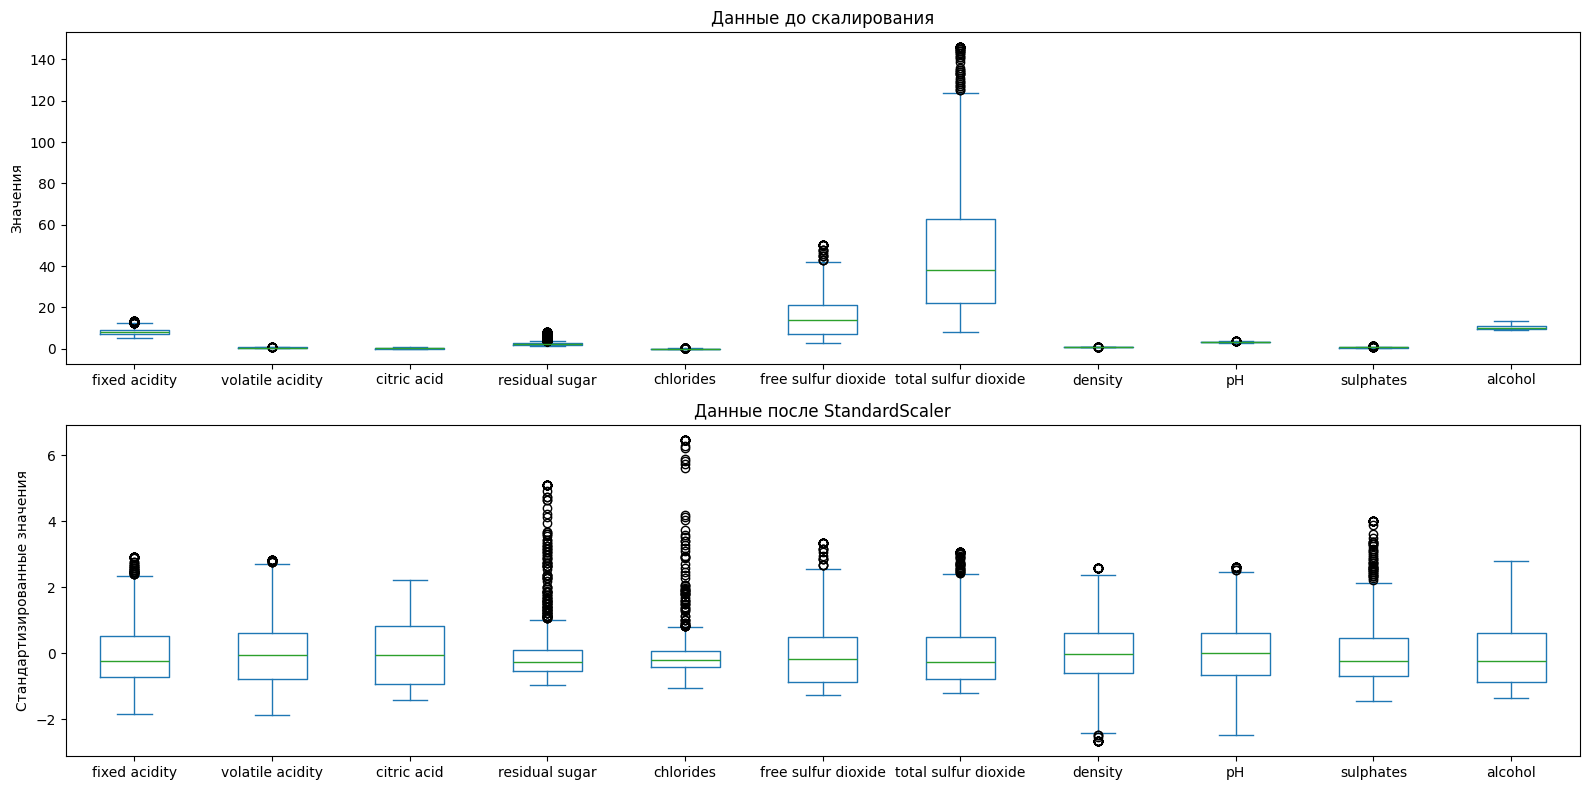

In [ ]:
# Разделяем на признаки и целевую переменную
X = df_no_outliers.drop('quality', axis=1)
y = df_no_outliers['quality']

# Визуализация распределения до скалирования
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# До скалирования
X.plot(kind='box', ax=ax1, title='Данные до скалирования')
ax1.set_ylabel('Значения')

# Скалирование (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# После скалирования
X_scaled_df.plot(kind='box', ax=ax2, title='Данные после StandardScaler')
ax2.set_ylabel('Стандартизированные значения')

plt.tight_layout()
plt.show()

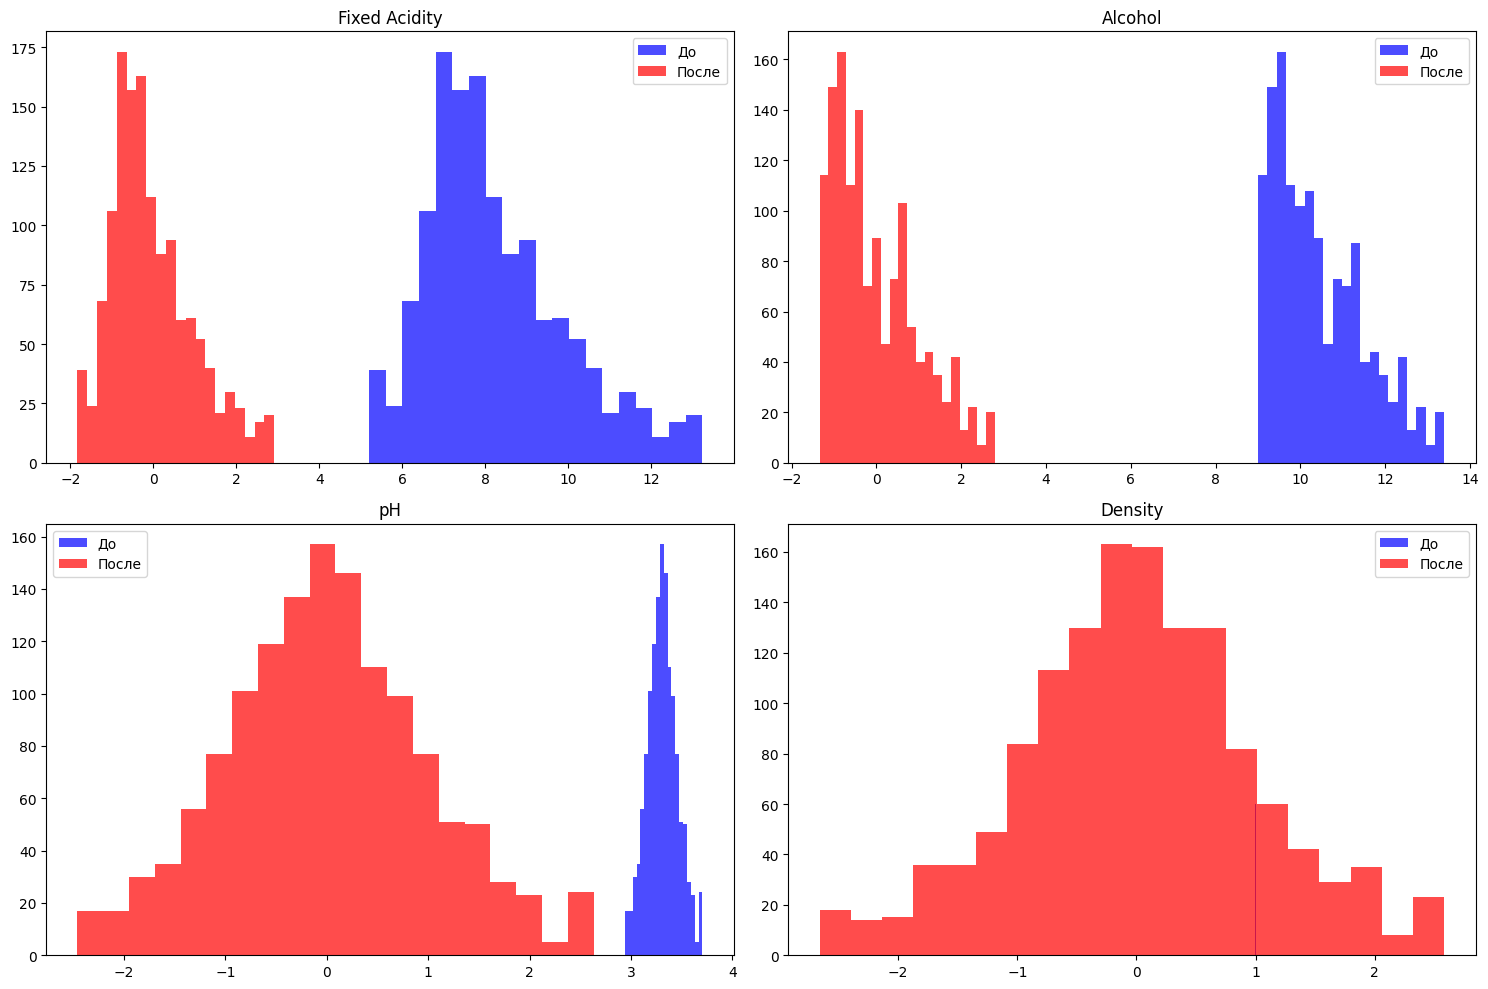

In [ ]:
# Визуализация распределения отдельных признаков до и после
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Fixed acidity
axes[0,0].hist(X['fixed acidity'], bins=20, alpha=0.7, label='До', color='blue')
axes[0,0].hist(X_scaled_df['fixed acidity'], bins=20, alpha=0.7, label='После', color='red')
axes[0,0].set_title('Fixed Acidity')
axes[0,0].legend()

# Alcohol
axes[0,1].hist(X['alcohol'], bins=20, alpha=0.7, label='До', color='blue')
axes[0,1].hist(X_scaled_df['alcohol'], bins=20, alpha=0.7, label='После', color='red')
axes[0,1].set_title('Alcohol')
axes[0,1].legend()

# pH
axes[1,0].hist(X['pH'], bins=20, alpha=0.7, label='До', color='blue')
axes[1,0].hist(X_scaled_df['pH'], bins=20, alpha=0.7, label='После', color='red')
axes[1,0].set_title('pH')
axes[1,0].legend()

# Density
axes[1,1].hist(X['density'], bins=20, alpha=0.7, label='До', color='blue')
axes[1,1].hist(X_scaled_df['density'], bins=20, alpha=0.7, label='После', color='red')
axes[1,1].set_title('Density')
axes[1,1].legend()

plt.tight_layout()
plt.show()

#### 7. Нормализация классов

In [ ]:
# Превращаем задачу в бинарную классификацию
y = (y >= 6).astype(int)

In [ ]:
y.value_counts()

,count
quality,
1,719
0,640


In [ ]:
# Избавляемся от дисбаланса классов
sm = SMOTE(random_state=RANDOM_STATE)
X_bal, y_bal = sm.fit_resample(X_scaled_df, y)
y_bal.value_counts()

,count
quality,
0,719
1,719


#### 8. Корреляционный анализ

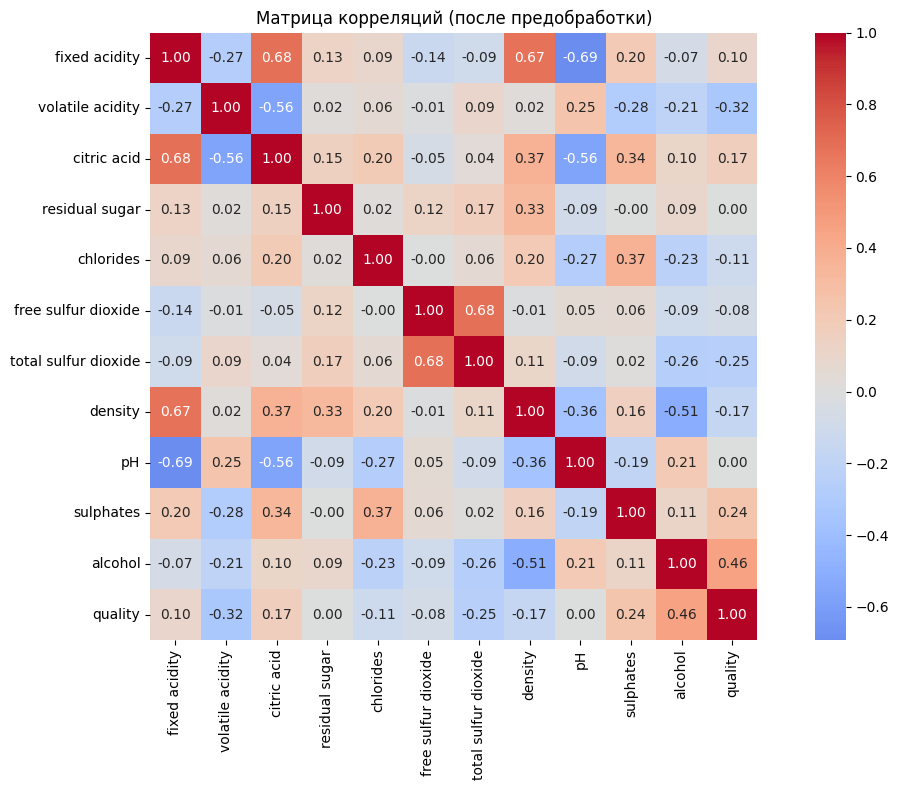

Корреляции с качеством вина:
quality                 1.000000
alcohol                 0.455759
sulphates               0.244315
citric acid             0.169271
fixed acidity           0.095406
pH                      0.001930
residual sugar          0.001896
free sulfur dioxide    -0.075059
chlorides              -0.113427
density                -0.166544
total sulfur dioxide   -0.254279
volatile acidity       -0.324563
Name: quality, dtype: float64


In [ ]:
plt.figure(figsize=(12, 8))
correlation_matrix = pd.concat([X_bal, y_bal], axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Матрица корреляций (после предобработки)')
plt.tight_layout()
plt.show()

# Корреляции с целевой переменной
quality_corr = correlation_matrix['quality'].sort_values(ascending=False)
print("Корреляции с качеством вина:")
print(quality_corr)

#### 9. Отчёт о предобработке данных

In [ ]:
print(f"Исходный размер: {df.shape}")
print(f"Финальный размер: {X_bal.shape}")
print(f"Целевая переменная: {y_bal.name}")
print(f"Уникальные значения качества: {sorted(y_bal.unique())}")
print(f"\nСтатистика после предобработки:")
print(X_bal.describe())

# Сохранение обработанных данных
final_data = pd.concat([X_bal, y_bal.reset_index(drop=True)], axis=1)
final_data.to_csv('winequality-red-preprocessed.csv', index=False)
print(f"\nОбработанные данные сохранены в 'winequality-red-processed.csv'")

Исходный размер: (1599, 12)
Финальный размер: (1438, 11)
Целевая переменная: quality
Уникальные значения качества: [np.int64(0), np.int64(1)]

Статистика после предобработки:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1438.000000       1438.000000  1438.000000     1438.000000   
mean       -0.005335          0.013882    -0.008527       -0.007203   
std         0.994855          0.997438     0.997412        0.987664   
min        -1.830430         -1.852360    -1.401618       -0.960725   
25%        -0.709242         -0.780145    -0.937346       -0.521653   
50%        -0.237163         -0.046524    -0.064946       -0.258209   
75%         0.529965          0.630665     0.764985        0.093048   
max         2.915145          2.827013     2.231052        5.098471   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1438.000000          1438.000000           1438.000000  1438.000000   
mean      0.005332           

#### 10. Разделение данных

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bal
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

np.savetxt('X_train.csv', X_train, delimiter=',')
np.savetxt('X_test.csv', X_test, delimiter=',')
np.savetxt('y_train.csv', y_train, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')

Размер обучающей выборки: (1150, 11)
Размер тестовой выборки: (288, 11)


### Шаги реализации
#### **1. Основные матрицы**
- **X_train** и **X_test** — это **матрицы данных**
  - строки = объекты (samples)
  - столбцы = признаки (features)
  - Размер X_train = (число объектов для обучения) × (число признаков)
  - Размер X_test = (число объектов для теста) × (число признаков)

- **y_train** и **y_test** — это **вектор целевых значений**
  - Используются для обучения/оценки модели
  - В SVD/PCA **не участвуют**

Пример:

| Dataset  | Размер | Что хранит |
|----------|--------|------------|
| X_train  | m × n  | m объектов, n признаков |
| X_test   | k × n  | k объектов, n признаков |
| y_train  | m × 1  | метки для обучающих объектов |
| y_test   | k × 1  | метки для тестовых объектов |

---

#### **2. Почему работаем только с X_train**
1. **Обучение только на тренировочных данных**
   - PCA/SVD вычисляют новые направления (главные компоненты) по X_train
   - Не используем X_test, чтобы избежать утечки информации (data leakage)

2. **Тестовые данные только для проверки модели**
   - После вычисления V_k на X_train проецируем X_test:
     ```
     X_test_PCA = (X_test - mean(X_train)) @ V_k
     ```
   - X_test **только оценивает качество**, не влияет на компоненты

3. **Стабильность и честная оценка**
   - Если делать SVD на X_test или объединении X_train + X_test → тестовые данные “подглядывают” → метрики будут завышены

---

#### **3. Вывод**
- **Все вычисления SVD, PCA (центрирование, V, Σ, выбор главных компонент)** → только на X_train  
- **X_test** проецируется на те же компоненты, чтобы честно оценить модель


### Шаг 1. Центрирование

In [ ]:
X_test = pd.read_csv('/content/X_test.csv', header=None)
X_test

,0,1,2,3,4,5,6,7,8,9,10
0,-1.004292,0.292071,-1.401618,-0.258209,0.290088,3.352117,0.510573,-0.696433,1.869979,0.152538,0.911437
1,-0.368672,0.880578,-0.254939,-0.516634,-0.083503,0.206797,1.491881,-0.341289,-0.006365,-1.120321,-0.851678
2,-0.827262,-0.723712,-0.679417,-0.082580,-0.055220,0.506752,-0.204315,0.052233,0.804308,-0.169355,-0.685297
3,-0.777102,0.286414,-1.298446,-0.447007,-0.333774,0.129002,-0.620821,-0.412685,0.378029,-0.162952,-0.272010
4,1.120064,-1.626630,1.126085,-0.082580,-0.285426,-0.572524,-0.577301,0.602724,-1.127222,-0.298113,-0.027818
...,...,...,...,...,...,...,...,...,...,...,...
283,-0.473203,-0.046524,0.661813,-0.258209,-0.630734,-0.376292,-0.825958,-1.081776,-0.327968,-0.104977,1.287140
284,-0.178153,-0.610847,0.249127,0.005234,-0.170323,0.997332,2.344418,0.718327,-0.594386,2.663310,-0.685297
285,-0.178153,0.404935,-0.266731,-0.346024,-0.170323,0.899216,1.816022,-0.316595,-0.061551,-1.070658,-0.497446
286,-0.119144,1.420718,-0.885760,0.707749,0.059883,-1.161220,-1.043532,1.015591,0.338076,-1.070658,-0.873148


In [ ]:
X_train = pd.read_csv('/content/X_train.csv', header=None)
X_train

,0,1,2,3,4,5,6,7,8,9,10
0,0.529965,-0.667280,1.177671,0.005234,-0.745837,-0.376292,-0.670547,-0.828551,0.204867,0.860705,2.696023
1,-0.075044,0.369287,-0.459486,-0.214773,-0.325403,-0.449616,0.758564,-0.167373,-0.576129,-1.230570,-1.084733
2,-1.299341,1.053908,-0.885760,0.093048,-0.791878,-0.278176,-0.608383,-1.698325,1.736770,-1.006279,1.381065
3,-0.709242,1.956826,-1.143689,2.815296,-0.124282,-1.259336,-1.012450,0.756861,0.604494,-0.877522,-0.215669
4,1.120064,-1.118739,0.971328,-0.521653,-0.147302,-0.964988,-1.167861,-0.234021,-1.393640,-1.135037,-0.027818
...,...,...,...,...,...,...,...,...,...,...,...
1145,2.300262,-1.062306,1.177671,-0.082580,-0.492611,-0.572524,-0.794876,1.813802,-1.260431,3.371476,-1.154925
1146,-0.237163,0.009909,-0.163559,-0.433838,-0.354487,-0.081944,1.816022,-0.388159,-0.261364,-0.748764,-0.967074
1147,-0.591223,-0.441550,0.455470,2.990925,-0.308446,-0.376292,1.256544,0.602724,0.138263,1.118220,0.066107
1148,-0.788397,0.009228,-0.069504,0.064130,-0.173836,-0.491747,-0.205440,0.075226,1.004121,-0.910876,0.412012


In [ ]:
X_mean = X_scaled.mean(axis=0)
X_centered = X_train - X_mean
X_centered

,0,1,2,3,4,5,6,7,8,9,10
0,0.529965,-0.667280,1.177671,0.005234,-0.745837,-0.376292,-0.670547,-0.828551,0.204867,0.860705,2.696023
1,-0.075044,0.369287,-0.459486,-0.214773,-0.325403,-0.449616,0.758564,-0.167373,-0.576129,-1.230570,-1.084733
2,-1.299341,1.053908,-0.885760,0.093048,-0.791878,-0.278176,-0.608383,-1.698325,1.736770,-1.006279,1.381065
3,-0.709242,1.956826,-1.143689,2.815296,-0.124282,-1.259336,-1.012450,0.756861,0.604494,-0.877522,-0.215669
4,1.120064,-1.118739,0.971328,-0.521653,-0.147302,-0.964988,-1.167861,-0.234021,-1.393640,-1.135037,-0.027818
...,...,...,...,...,...,...,...,...,...,...,...
1145,2.300262,-1.062306,1.177671,-0.082580,-0.492611,-0.572524,-0.794876,1.813802,-1.260431,3.371476,-1.154925
1146,-0.237163,0.009909,-0.163559,-0.433838,-0.354487,-0.081944,1.816022,-0.388159,-0.261364,-0.748764,-0.967074
1147,-0.591223,-0.441550,0.455470,2.990925,-0.308446,-0.376292,1.256544,0.602724,0.138263,1.118220,0.066107
1148,-0.788397,0.009228,-0.069504,0.064130,-0.173836,-0.491747,-0.205440,0.075226,1.004121,-0.910876,0.412012


### Шаг 2. Вычисление нормальной матрицы XᵀX

**Что делаем:**  
- Строим квадратную симметричную матрицу:

M = X_centered^T · X_centered

- Размер M = `(n × n)`, где n — число признаков  
- M показывает, как признаки **связаны между собой**

**Почему это важно:**  
- Собственные векторы M → это **правые сингулярные векторы (V)**  
- Квадраты сингулярных чисел σ² → **собственные числа λ**  
- Эти данные необходимы для построения **матриц Σ и U** в SVD


In [ ]:
M = np.dot(X_centered.T, X_centered)
print(M.shape)

(11, 11)


### Шаг 3. SVD-разложение

#### **Нахождение собственных чисел и векторов (правые сингулярные векторы)**

**Цель:**  
- Найти собственные числа λ и собственные векторы V матрицы M = X_centered^T · X_centered  
- Эти данные нужны для построения SVD и последующего PCA

---

#### 1. **QR-алгоритм**

- QR-алгоритм — это способ вычислить собственные числа и векторы без готовых функций `eig`
- Идея: разложить матрицу A на Q и R и повторять итерации

**Пошагово:**

1. **Инициализация:**  

A = M

- M — матрица X_centered^T · X_centered

2. **Итерации:**  
Для каждой итерации k:

Q_k, R_k = QR-разложение(A_k)

A_{k+1} = R_k @ Q_k

- Q_k — ортогональная матрица  
- R_k — верхнетреугольная матрица  

3. **Сходимость:**  
- После нескольких итераций A_k станет почти диагональной  
- Диагональ ≈ собственные числа λ

4. **Собственные векторы:**  
- Накопительная матрица Q → столбцы → собственные векторы (V)

---

#### **2. Вычисление сингулярных чисел**

\[
\sigma_i = \sqrt{\lambda_i}
\]

- σ_i → диагональ матрицы Σ  
- Показатель “силы” каждой главной компоненты

---

#### **3. Для чего это нужно**

- Собственные числа → сколько информации несёт каждая компонента  
- Собственные векторы → направление новой оси в признаковом пространстве  
- Это позволяет построить **матрицу U** и **полное SVD**, а затем перейти к **PCA**


QR-разложение через модифицированный Грамм–Шмидт

In [ ]:
def qr_gram_schmidt(A):
    n = A.shape[0]  # число признаков (столбцов и строк в M)
    Q = np.zeros_like(A, dtype=float) # создаём пустую матрицу Q того же размера
    R = np.zeros((n,n), dtype=float) # верхнетреугольная матрица R

    for i in range(n):
        v = A[:, i].copy()
        for j in range(i):
            R[j, i] = np.dot(Q[:, j], v)
            v = v - R[j, i] * Q[:, j]
        R[i, i] = np.linalg.norm(v)
        Q[:, i] = v / R[i, i]

    return Q, R

QR-алгоритм для поиска собственных чисел и векторов

In [ ]:
def qr_algorithm(A, num_iter=200):
    n = A.shape[0]
    A_k = A.copy()   # копируем исходную матрицу, чтобы не менять её
    Q_total = np.eye(n)  # начальная единичная матрица для накопления Q

    for _ in range(num_iter):
        Q, R = qr_gram_schmidt(A_k)  # QR-разложение через Грамм–Шмидт
        A_k = np.dot(R, Q)   # обновляем матрицу A_k
        Q_total = np.dot(Q_total, Q) # накопление Q для собственных векторов

    eigenvalues = np.diag(A_k)  # собственные числа ≈ диагональ A_k
    eigenvectors = Q_total  # столбцы = собственные векторы

    return eigenvalues, eigenvectors

Получение сингулярных чисел и матрицы Σ

In [ ]:
eigenvalues, V = qr_algorithm(M)   # применяем QR-алгоритм

# Сингулярные числа
singular_values = np.sqrt(np.abs(eigenvalues))  # sqrt(λ)

Вычисление левых сингулярных векторов

In [ ]:
# Σ^-1
eps = 1e-10
Sigma_inv = np.diag(1 / (singular_values + eps))

# U = X_centered dot V dot Σ^-1
U = np.dot(np.dot(X_centered, V), Sigma_inv)

### Шаг 4. реализации SVD/PCA

Построение PCA-преобразования

In [ ]:
#Вычисляем объяснённую дисперсию
explained_variance = singular_values**2 / np.sum(singular_values**2)
cumulative_variance = np.cumsum(explained_variance)



# Выбираем k компонент
k = np.argmax(cumulative_variance >= 0.90) + 1

In [ ]:
# Преобразование данных в PCA-пространство
V_k = V[:, :k]  # выбираем первые k правых сингулярных векторов

# Проецирование данных
X_train_PCA = np.dot(X_centered, V_k)

X_test_centered = X_test - X_mean
X_test_PCA = np.dot(X_test_centered, V_k)

print(f"Выбрано {k} компонент для PCA (≈{cumulative_variance[k-1]*100:.1f}% объяснённой дисперсии)")


Выбрано 7 компонент для PCA (≈91.4% объяснённой дисперсии)


In [ ]:
# Создаём имена колонок для PCA-компонент
columns = [f'PC{i+1}' for i in range(X_train_PCA.shape[1])]

# Преобразуем numpy-массивы в DataFrame
df_train = pd.DataFrame(X_train_PCA, columns=columns)
df_test = pd.DataFrame(X_test_PCA, columns=columns)

# Сохраняем в CSV
df_train.to_csv('PCA_train.csv', index=False)
df_test.to_csv('PCA_test.csv', index=False)

print("Датасеты сохранены: PCA_train.csv и PCA_test.csv")

Датасеты сохранены: PCA_train.csv и PCA_test.csv


### Шаг 5. Визуализация

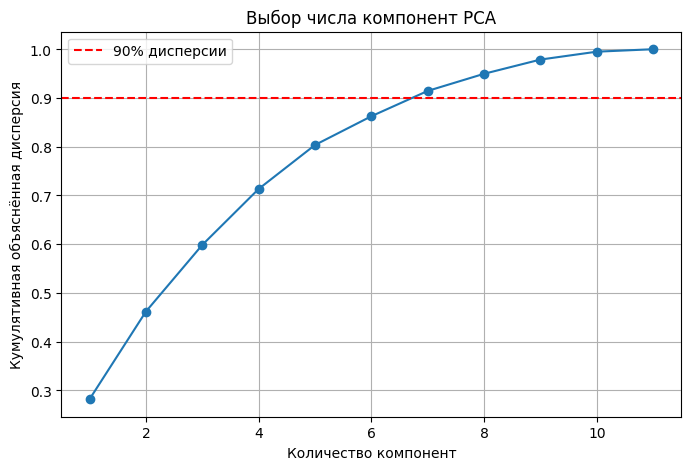

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% дисперсии')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объяснённая дисперсия')
plt.title('Выбор числа компонент PCA')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
y_train = pd.read_csv('/content/y_train.csv', header=None)
y_test = pd.read_csv('/content/y_test.csv', header=None)

In [ ]:
# Сохраняем в CSV
y_train.to_csv('y_bin_train.csv', index=False)
y_test.to_csv('y_bin_test.csv', index=False)

# Датасеты имеют заголовки колонок!!! (проверь размер)
print("Датасеты сохранены: y_bin_train.csv и y_bin_test.csv")

Датасеты сохранены: y_bin_train.csv и y_bin_test.csv


Scatter plot первых 2 компонент

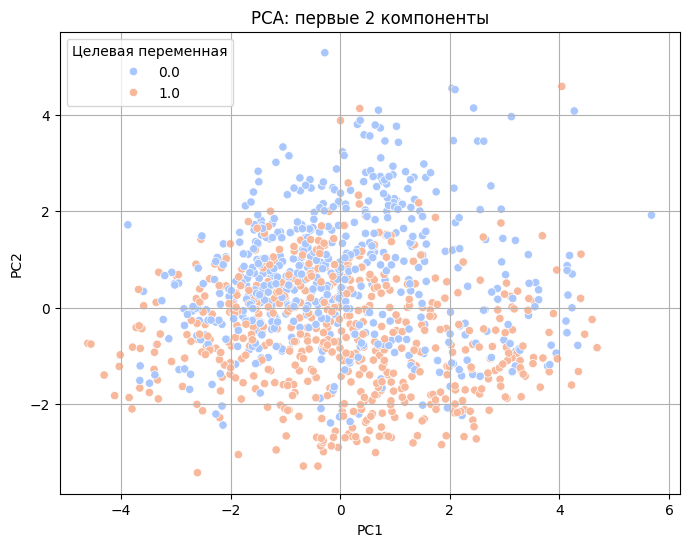

In [ ]:
# Преобразуем X_train_PCA в DataFrame
df_pca = df_train.iloc[:, :2]
df_pca['target'] = y_train  # добавляем целевую переменную

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='target', palette='coolwarm')
plt.title('PCA: первые 2 компоненты')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Целевая переменная')
plt.grid(True)
plt.show()

Scatter plot первых 3 компонент

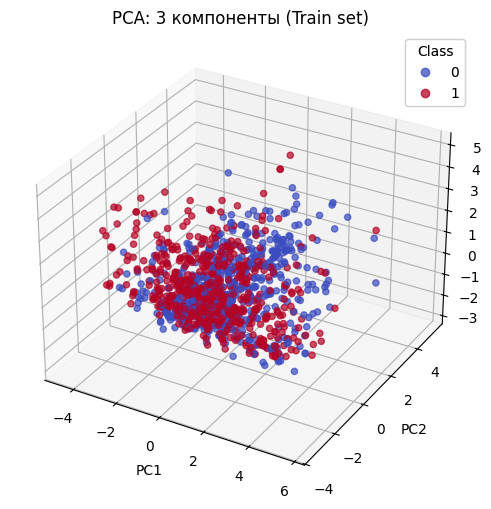

In [ ]:
# Берем первые три компоненты
X_3D = df_train.iloc[:, :3]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Рисуем точки, цвет = класс
scatter = ax.scatter(
    X_3D.iloc[:,0], X_3D.iloc[:,1], X_3D.iloc[:,2],
    c=y_train, cmap='coolwarm', alpha=0.7
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA: 3 компоненты (Train set)')

# Легенда для классов
legend1 = ax.legend(*scatter.legend_elements(), title="Class")
ax.add_artist(legend1)

plt.show()

### Загрузка обучающего датасета

In [ ]:
X_train = pd.read_csv('/content/X_train.csv', header=None)
X_test = pd.read_csv('/content/X_test.csv', header=None)

X_train_PCA = pd.read_csv('/content/PCA_train.csv')
X_test_PCA = pd.read_csv('/content/PCA_test.csv')

y_train = pd.read_csv('/content/y_bin_train.csv')
y_test = pd.read_csv('/content/y_bin_test.csv')

### Обучение без PCA

In [ ]:
# Optuna
def objective(trial, X, y):
    # Гиперпараметры для подбора
    hidden_layer_sizes = tuple([
        trial.suggest_int(f'n_units_l{i}', 10, 200)
        for i in range(trial.suggest_int('n_layers', 1, 3))
    ])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)

    # Пайплайн: стандартизация + классификатор
    model = Pipeline([
        ('mlp', MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            learning_rate_init=learning_rate_init,
            max_iter=500,
            random_state=RANDOM_STATE
        ))
    ])

    # Кросс-валидация с учётом пропорций классов
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    return np.mean(scores)

In [ ]:
def show_results(model_params, X_train, X_test, y_train, y_test):
    hidden_layer_sizes = tuple([
        model_params[f'n_units_l{i}'] for i in range(model_params['n_layers'])
    ])

    # Инициализация модели
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=model_params['activation'],                    # activation
        solver=model_params['solver'],                            # solver
        alpha=model_params['alpha'],                              # L2-регуляризация
        learning_rate_init=model_params['learning_rate_init'],    # скорость обучения
        max_iter=5000,
        random_state=RANDOM_STATE
    )

    # Обучение
    mlp.fit(X_train, y_train)

    # Предсказание
    y_pred = mlp.predict(X_test)
    y_proba = mlp.predict_proba(X_test)[:, 1]

    # Метрики
    acc = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {acc:.4f}")

    report = classification_report(y_test, y_pred, target_names=['Класс 0', 'Класс 1'])
    print(report)

    # ROC/AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая MLPClassifier без PCA')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Кривая обучения
    plt.figure(figsize=(6,4))
    plt.plot(mlp.loss_curve_)
    plt.title("Кривая потерь MLP")
    plt.xlabel("Итерации")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

In [ ]:
# Запуск подбора
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

# Результаты
print("Лучшее значение accuracy:", study.best_value)
print("Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-07 08:57:46,361] A new study created in memory with name: no-name-6507b99d-7561-49d4-95cf-9cd6d2171af9
[I 2025-11-07 08:57:53,050] Trial 0 finished with value: 0.7469565217391304 and parameters: {'n_layers': 1, 'n_units_l0': 162, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0002504405464289519, 'learning_rate_init': 0.0012544210176886402}. Best is trial 0 with value: 0.7469565217391304.
[I 2025-11-07 08:59:22,928] Trial 1 finished with value: 0.7356521739130434 and parameters: {'n_layers': 3, 'n_units_l0': 27, 'n_units_l1': 69, 'n_units_l2': 185, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.003058718915528435, 'learning_rate_init': 0.00036332038311308237}. Best is trial 0 with value: 0.7469565217391304.
[I 2025-11-07 08:59:24,186] Trial 2 finished with value: 0.5756521739130435 and parameters: {'n_layers': 1, 'n_units_l0': 91, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 6.575902945332001e-05, 'learning_rate_init': 0.00012205669483806073}. Best is tria

Лучшее значение accuracy: 0.76
Лучшие гиперпараметры:
  n_layers: 2
  n_units_l0: 89
  n_units_l1: 120
  activation: tanh
  solver: adam
  alpha: 0.0009538946007607056
  learning_rate_init: 0.00022463142294896674



Accuracy: 0.7118
              precision    recall  f1-score   support

     Класс 0       0.71      0.72      0.71       144
     Класс 1       0.72      0.70      0.71       144

    accuracy                           0.71       288
   macro avg       0.71      0.71      0.71       288
weighted avg       0.71      0.71      0.71       288



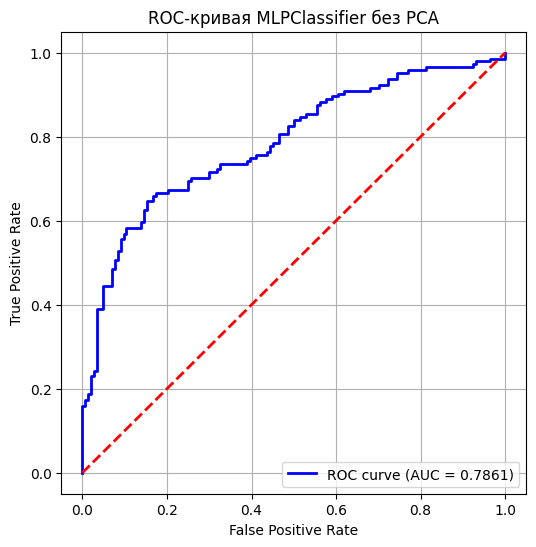

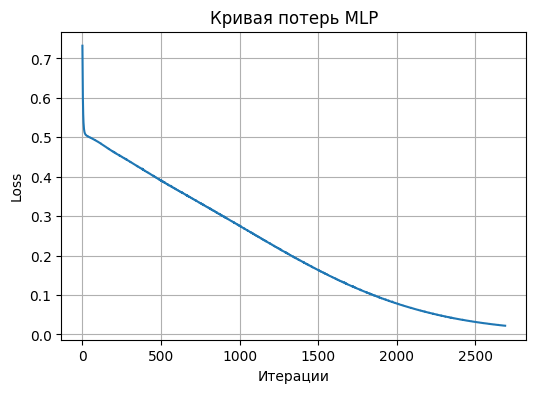

In [ ]:
show_results(study.best_params, X_train, X_test, y_train, y_test)

### Обучение с PCA

In [ ]:
# Запуск подбора
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_PCA, y_train), n_trials=50)

# Результаты
print("Лучшее значение accuracy:", study.best_value)
print("Лучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-07 09:13:11,025] A new study created in memory with name: no-name-19a85186-bd6e-48ac-92bb-c6233e39e1bf
[I 2025-11-07 09:13:36,151] Trial 0 finished with value: 0.7252173913043479 and parameters: {'n_layers': 2, 'n_units_l0': 53, 'n_units_l1': 134, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.008527171995085993, 'learning_rate_init': 0.00015545464225621248}. Best is trial 0 with value: 0.7252173913043479.
[I 2025-11-07 09:13:43,633] Trial 1 finished with value: 0.7017391304347825 and parameters: {'n_layers': 2, 'n_units_l0': 55, 'n_units_l1': 182, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0002329594019876852, 'learning_rate_init': 0.08024503402533524}. Best is trial 0 with value: 0.7252173913043479.
[I 2025-11-07 09:13:45,389] Trial 2 finished with value: 0.5 and parameters: {'n_layers': 3, 'n_units_l0': 194, 'n_units_l1': 36, 'n_units_l2': 49, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 2.267115700640684e-05, 'learning_rate_init': 0.0002441881206280924}.

Лучшее значение accuracy: 0.7547826086956523
Лучшие гиперпараметры:
  n_layers: 1
  n_units_l0: 184
  activation: tanh
  solver: adam
  alpha: 6.399636962952165e-05
  learning_rate_init: 0.0007768775965569156



Accuracy: 0.6944
              precision    recall  f1-score   support

     Класс 0       0.70      0.69      0.69       144
     Класс 1       0.69      0.70      0.70       144

    accuracy                           0.69       288
   macro avg       0.69      0.69      0.69       288
weighted avg       0.69      0.69      0.69       288



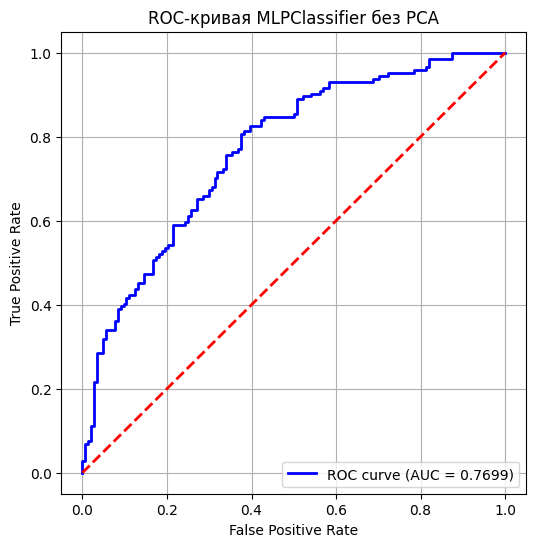

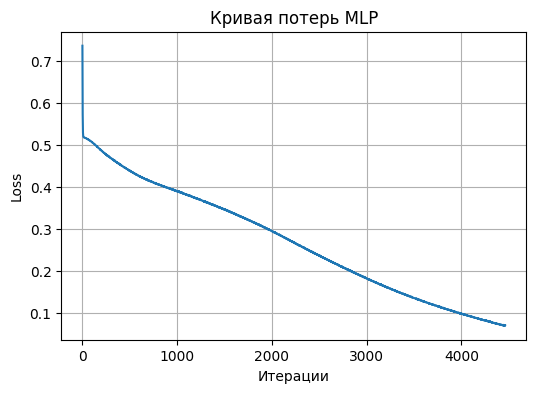

In [ ]:
show_results(study.best_params, X_train_PCA, X_test_PCA, y_train, y_test)

## Часть 2. Kernel PCA

#### Загружеаем данные

In [ ]:
N_COMPONENTS = 7 # Из визуализации в PCA

X_train = pd.read_csv('/content/X_train.csv', header=None)
X_test = pd.read_csv('/content/X_test.csv', header=None)

y_train = pd.read_csv('/content/y_bin_train.csv')
y_test = pd.read_csv('/content/y_bin_test.csv')

### Kernels

In [ ]:
def _ensure_2d_array(X):
  """
  Гарантируем, что вход — numpy array с двумя измерениями: (n_samples, n_features).
  Если X одномерный (n,), превращаем в (n,1).
  Это упрощает обработку в остальных функциях.
  """
  arr_X = np.asarray(X, dtype=float)
  if arr_X.ndim == 1:
    arr_X = arr_X.reshape(-1, 1)
  return arr_X

**Полиномиальное ядро:**  
*K(x,y) = (gamma * <x,y> + coef0)^degree*


  Аргументы:  
  X: массив формы (n_samples_X, n_features)  
  Y: массив формы (n_samples_Y, n_features)   
  degree: степень полинома (целое >=1)  
  gamma: множитель перед скалярным произведением  
  coef0: смещение (c_0)

  Возвращает:  
  матрицу размера K (n_samples_X, n_samples_Y)

In [ ]:
def polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1.0):
  ensure_X = _ensure_2d_array(X)
  if Y is None:
    ensure_Y = ensure_X
  else:
    ensure_Y = _ensure_2d_array(Y)

  n_features = ensure_X.shape[1]
  if gamma is None:
    gamma = 1.0 / max(1, n_features) # защита от деления на ноль

  # Вычисляем матрицу попарных скалярных произведений
  G = ensure_X @ ensure_Y.T # (n_x, n_y)

  # Возводим по формуле ядра
  K = (gamma * G + coef0) ** degree
  return K

**Радиальное базисное (Gaussian) ядро:**  
*K(x,y) = exp(-gamma * ||x-y||^2)*


  Для эффективности используем трюк с нормами:  
*||x-y||^2 = ||x||^2 + ||y||^2 - 2 <x,y>*


  Аргументы:  
  gamma: если None -> 1/n_features


  Возвращает матрицу (n_x, n_y).

In [ ]:
def rbf_kernel(X, Y=None, gamma=None):
  ensure_X = _ensure_2d_array(X)
  if Y is None:
    ensure_Y = ensure_X
  else:
    ensure_Y = _ensure_2d_array(Y)

  n_features = ensure_X.shape[1]
  if gamma is None:
    gamma = 1.0 / max(1, n_features)


  # Вектор норм квадратов: ||x||^2 по каждому x
  X_norm2 = np.sum(ensure_X ** 2, axis=1).reshape(-1, 1) # (n_x, 1)
  Y_norm2 = np.sum(ensure_Y ** 2, axis=1).reshape(1, -1) # (1, n_y)


  # Попарные квадраты расстояний
  # Используем матричное выражение вместо циклов
  sq_dists = X_norm2 + Y_norm2 - 2.0 * (ensure_X @ ensure_Y.T)


  # Числовая устойчивость: из-за погрешностей могут появиться маленькие
  # отрицательные значения (например -1e-15). Обрезаем их до 0.
  sq_dists = np.maximum(sq_dists, 0.0)


  # Наконец, применяем экспоненту
  K = np.exp(-gamma * sq_dists)
  return K

**Сигмоидальное (tanh) ядро:**  
*K(x,y) = tanh(gamma * <x,y> + coef0)*


  

In [ ]:
def sigmoid_kernel(X, Y=None, gamma=None, coef0=0.0):
  ensure_X = _ensure_2d_array(X)
  if Y is None:
    ensure_Y = ensure_X
  else:
    ensure_Y = _ensure_2d_array(Y)

  n_features = ensure_X.shape[1]
  if gamma is None:
    gamma = 1.0 / max(1, n_features)


  G = ensure_X @ ensure_Y.T
  K = np.tanh(gamma * G + coef0)
  return K

**Центрирование матрицы ядра K** (K — квадратная матрица n x n)

In [ ]:
def center_kernel(K):
  K = np.asarray(K, dtype=float)
  if K.ndim != 2 or K.shape[0] != K.shape[1]:
    raise ValueError("K должна быть квадратной матрицей размера (n, n)")


  n = K.shape[0]
  one_n = np.ones((n, n), dtype=float) / float(n)

  Kc = K - one_n @ K - K @ one_n + one_n @ K @ one_n

  return Kc

**Спектральное разложение** симметричной матрицы K.


  Возвращает:  
  eigvals: собственные значения, отсортированные по убыванию (размер m)  
  eigvecs: соответствующие столбцы собственных векторов (shape (n, m))  


  Аргументы:  
  n_components: если указано, возвращаем только первые n_components   
  eps: порог для обнуления очень маленьких отрицательных eigenvalues



  Почему используем np.linalg.eigh?
  - eigh оптимизирован для симметричных/Hermitian матриц и более
  численно устойчив, чем общий eig.

In [ ]:
def spectral_decompose(K, n_components=None, eps=1e-12):
  K = np.asarray(K, dtype=float)
  if K.ndim != 2 or K.shape[0] != K.shape[1]:
    raise ValueError("K должна быть квадратной матрицей размером (n, n)")

  n = K.shape[0]

  # Симметризуем: это помогает устранить малые несимметрии из-за численных ошибок
  K_sym = (K + K.T) / 2.0

  # eigh возвращает собственные значения по возрастанию; eigenvectors — столбцы
  eigvals, eigvecs = np.linalg.eigh(K_sym)

  # Сортируем по убыванию собственных значений, т.к. главные компоненты — с большими значениями
  order = np.argsort(eigvals)[::-1]
  eigvals = eigvals[order]
  eigvecs = eigvecs[:, order]

  # Числовая обработка: маленькие отрицательные значения превращаем в ноль
  eigvals_clean = np.where(eigvals > -eps, np.maximum(eigvals, 0.0), eigvals)


  if n_components is not None:
    if n_components <= 0:
      raise ValueError("n_components должно быть положительным целым числом или None")
    eigvals_clean = eigvals_clean[:n_components]
    eigvecs = eigvecs[:, :n_components]


  return eigvals_clean, eigvecs

In [ ]:
print("Вычисляем ядерные матрицы (polynomial, rbf, sigmoid)")
K_poly = polynomial_kernel(X_train, degree=3, gamma=None, coef0=1.0)
K_rbf = rbf_kernel(X_train, gamma=None)
K_sig = sigmoid_kernel(X_train, gamma=None, coef0=0.0)

print("Формы ядерных матриц:", K_poly.shape, K_rbf.shape, K_sig.shape)

Вычисляем ядерные матрицы (polynomial, rbf, sigmoid)
Формы ядерных матриц: (1150, 1150) (1150, 1150) (1150, 1150)


In [ ]:
# Центрирование ядерных матриц
K_poly_c = center_kernel(K_poly)
K_rbf_c = center_kernel(K_rbf)
K_sig_c = center_kernel(K_sig)

In [ ]:
# Получение собственных значений и векторов
eval_poly, evecs_poly = spectral_decompose(K_poly_c)
eval_rbf, evecs_rbf = spectral_decompose(K_rbf_c)
eval_sig, evecs_sig = spectral_decompose(K_sig_c)

In [ ]:
# Сортируем по убыванию собственных значений
# poly
idx = np.argsort(eval_poly)[::-1]
eval_poly = eval_poly[idx]
evecs_poly = evecs_poly[:, idx]

# rbf
idx = np.argsort(eval_rbf)[::-1]
eval_rbf = eval_rbf[idx]
evecs_rbf = evecs_rbf[:, idx]

# sig
idx = np.argsort(eval_sig)[::-1]
eval_sig = eval_sig[idx]
evecs_sig = evecs_sig[:, idx]

In [ ]:
def components_visualisation(cumulativa_variance, disp):
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
    plt.axhline(y=disp, color='r', linestyle='--', label=f'{disp*100}% дисперсии')
    plt.xlabel('Количество компонент')
    plt.ylabel('Кумулятивная объяснённая дисперсия')
    plt.title('Выбор числа компонент PCA')
    plt.grid(True)
    plt.legend()
    plt.show()

35 компонент обеспечивает KPCA poly (≈90.0% объяснённой дисперсии)


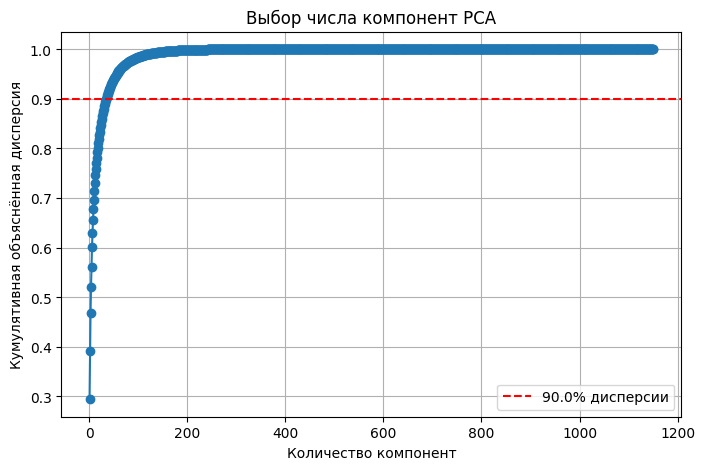

71 компонент обеспечивает KPCA rbf (≈85.1% объяснённой дисперсии)


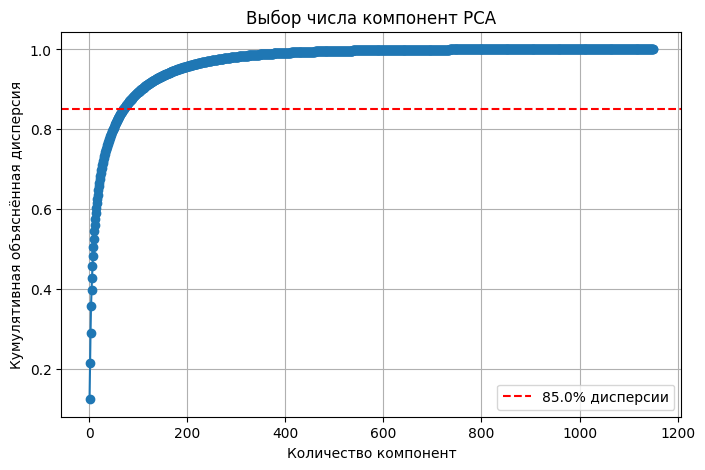

10 компонент обеспечивает KPCA sig (≈75.9% объяснённой дисперсии)


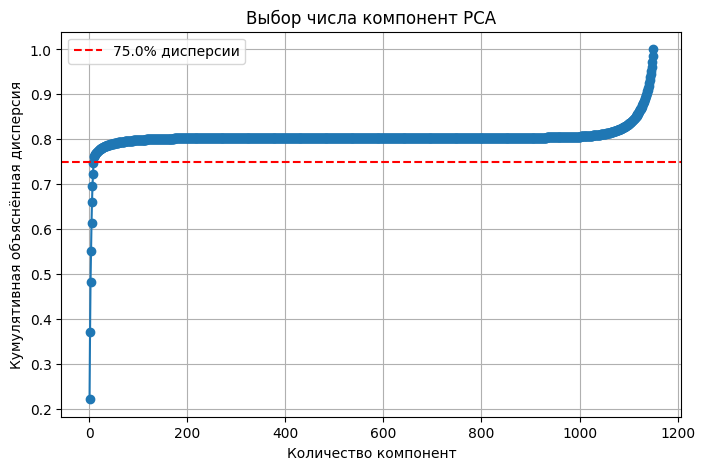

In [ ]:
k = [0, 0, 0]

# Сингулярные числа и объяснённая дисперсия
singular_values_poly = np.sqrt(np.abs(eval_poly))  # sqrt(λ)
explained_variance = singular_values_poly**2 / np.sum(singular_values_poly**2)
cumulative_variance = np.cumsum(explained_variance)
k[0] = np.argmax(cumulative_variance >= 0.90) + 1
print(f"{k[0]} компонент обеспечивает KPCA poly (≈{cumulative_variance[k[0]-1]*100:.1f}% объяснённой дисперсии)")
components_visualisation(cumulative_variance, 0.90)

singular_values_rbf = np.sqrt(np.abs(eval_rbf))
explained_variance = singular_values_rbf**2 / np.sum(singular_values_rbf**2)
cumulative_variance = np.cumsum(explained_variance)
k[1] = np.argmax(cumulative_variance >= 0.85) + 1
print(f"{k[1]} компонент обеспечивает KPCA rbf (≈{cumulative_variance[k[1]-1]*100:.1f}% объяснённой дисперсии)")
components_visualisation(cumulative_variance, 0.85)

singular_values_sig = np.sqrt(np.abs(eval_sig))
explained_variance = singular_values_sig**2 / np.sum(singular_values_sig**2)
cumulative_variance = np.cumsum(explained_variance)
k[2] = np.argmax(cumulative_variance >= 0.75) + 1
print(f"{k[2]} компонент обеспечивает KPCA sig (≈{cumulative_variance[k[2]-1]*100:.1f}% объяснённой дисперсии)")
components_visualisation(cumulative_variance, 0.75)

In [ ]:
# Проекция данных
kernels = ['poly', 'rbf', 'sigmoid']
kpca_results = {}

one_n_train = np.ones((X_train.shape[0], X_train.shape[0])) / X_train.shape[0]
one_n_test = np.ones((X_test.shape[0], X_train.shape[0])) / X_train.shape[0]

for kernel in kernels:
    if kernel == 'poly':
        alphas = evecs_poly[:, :k[0]]
        lambdas = eval_poly[:k[0]]
        k_test = polynomial_kernel(X_test, X_train, degree=3, gamma=None, coef0=1.0)
    elif kernel == 'rbf':
        alphas = evecs_rbf[:, :k[1]]
        lambdas = eval_rbf[:k[1]]
        k_test = rbf_kernel(X_test, X_train, gamma=None)
    elif kernel == 'sigmoid':
        alphas = evecs_sig[:, :k[1]]
        lambdas = eval_sig[:k[1]]
        k_test = sigmoid_kernel(X_test, X_train, gamma=None, coef0=0.0)

    kpca_train = np.sqrt(lambdas) * alphas
    k_test_centered = (k_test - one_n_test @ np.asarray(K_poly, dtype=float) - k_test @ one_n_train + one_n_test @ np.asarray(K_poly, dtype=float) @ one_n_train)
    kpca_test = k_test_centered @ (alphas / np.sqrt(lambdas))
    kpca_results[kernel] = kpca_train, kpca_test

### Обучение с KPCA

In [ ]:
kpca_best_params = {}
for kernel, X_kpca in kpca_results.items():
    X_train, _ = X_kpca
    # Запуск подбора
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=50)

    # Результаты
    print("Лучшее значение accuracy:", study.best_value)
    print("Лучшие гиперпараметры:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    kpca_best_params[kernel] = study.best_params

[I 2025-11-07 09:33:01,959] A new study created in memory with name: no-name-245f3c14-794d-4e3e-8442-4578f79f3fa1
[I 2025-11-07 09:34:07,636] Trial 0 finished with value: 0.7252173913043478 and parameters: {'n_layers': 3, 'n_units_l0': 157, 'n_units_l1': 200, 'n_units_l2': 37, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.000281823286300189, 'learning_rate_init': 0.000108493165107818}. Best is trial 0 with value: 0.7252173913043478.
[I 2025-11-07 09:34:26,066] Trial 1 finished with value: 0.7095652173913043 and parameters: {'n_layers': 2, 'n_units_l0': 94, 'n_units_l1': 121, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.000930273384225774, 'learning_rate_init': 0.03453212494577952}. Best is trial 0 with value: 0.7252173913043478.
[I 2025-11-07 09:35:25,711] Trial 2 finished with value: 0.7504347826086957 and parameters: {'n_layers': 3, 'n_units_l0': 62, 'n_units_l1': 154, 'n_units_l2': 165, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.0005789545278427455, 'learning_ra

Лучшее значение accuracy: 0.7608695652173914
Лучшие гиперпараметры:
  n_layers: 1
  n_units_l0: 166
  activation: relu
  solver: sgd
  alpha: 6.441524446838949e-05
  learning_rate_init: 0.007225823025049729


[I 2025-11-07 09:53:15,130] Trial 0 finished with value: 0.7173913043478262 and parameters: {'n_layers': 1, 'n_units_l0': 108, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00017079589187787972, 'learning_rate_init': 0.02959049532863563}. Best is trial 0 with value: 0.7173913043478262.
[I 2025-11-07 09:53:40,629] Trial 1 finished with value: 0.7008695652173913 and parameters: {'n_layers': 1, 'n_units_l0': 184, 'activation': 'relu', 'solver': 'adam', 'alpha': 5.5186844904210434e-05, 'learning_rate_init': 0.0026494142492312755}. Best is trial 0 with value: 0.7173913043478262.
[I 2025-11-07 09:53:53,888] Trial 2 finished with value: 0.751304347826087 and parameters: {'n_layers': 3, 'n_units_l0': 198, 'n_units_l1': 131, 'n_units_l2': 199, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0027525495054330613, 'learning_rate_init': 0.004376094834645341}. Best is trial 2 with value: 0.751304347826087.
[I 2025-11-07 09:54:22,995] Trial 3 finished with value: 0.7295652173913043 and pa

Лучшее значение accuracy: 0.7582608695652174
Лучшие гиперпараметры:
  n_layers: 2
  n_units_l0: 22
  n_units_l1: 188
  activation: logistic
  solver: adam
  alpha: 1.5108542390244983e-05
  learning_rate_init: 0.0004877527880368214


[I 2025-11-07 10:09:54,507] Trial 0 finished with value: 0.7026086956521739 and parameters: {'n_layers': 2, 'n_units_l0': 98, 'n_units_l1': 182, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.00011877609917220299, 'learning_rate_init': 0.03405527668676401}. Best is trial 0 with value: 0.7026086956521739.
[I 2025-11-07 10:09:56,313] Trial 1 finished with value: 0.5147826086956522 and parameters: {'n_layers': 3, 'n_units_l0': 36, 'n_units_l1': 137, 'n_units_l2': 73, 'activation': 'logistic', 'solver': 'adam', 'alpha': 3.719996153990828e-05, 'learning_rate_init': 0.00011209805098439244}. Best is trial 0 with value: 0.7026086956521739.
[I 2025-11-07 10:10:03,526] Trial 2 finished with value: 0.7373913043478261 and parameters: {'n_layers': 1, 'n_units_l0': 36, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00018486853065989938, 'learning_rate_init': 0.0002796067007340744}. Best is trial 2 with value: 0.7373913043478261.
[I 2025-11-07 10:10:05,388] Trial 3 finished with value: 0.

Лучшее значение accuracy: 0.7608695652173914
Лучшие гиперпараметры:
  n_layers: 1
  n_units_l0: 121
  activation: relu
  solver: sgd
  alpha: 0.0006442636559867537
  learning_rate_init: 0.015804088068705986


Визуализация для KPCA poly

Accuracy: 0.7396
              precision    recall  f1-score   support

     Класс 0       0.72      0.78      0.75       144
     Класс 1       0.76      0.70      0.73       144

    accuracy                           0.74       288
   macro avg       0.74      0.74      0.74       288
weighted avg       0.74      0.74      0.74       288



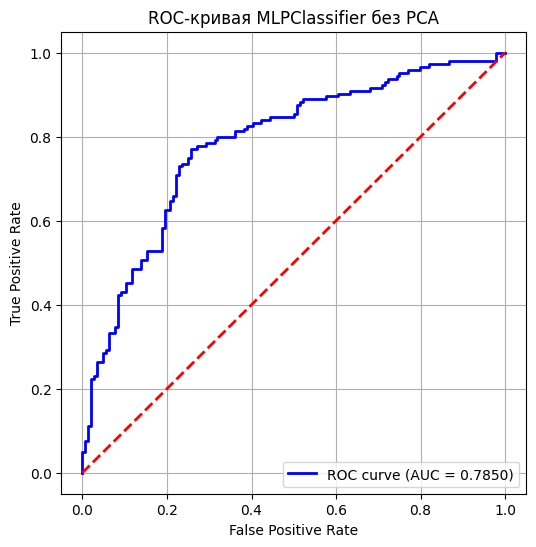

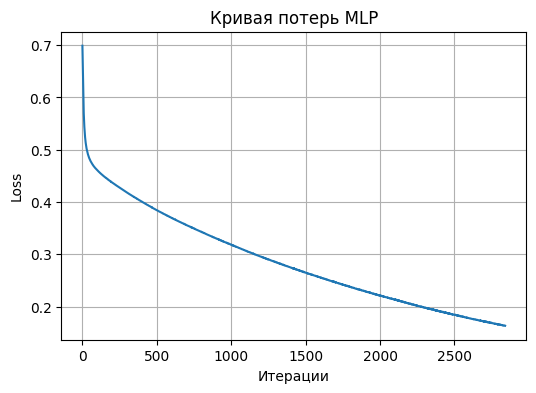

Визуализация для KPCA rbf

Accuracy: 0.7083
              precision    recall  f1-score   support

     Класс 0       0.64      0.95      0.77       144
     Класс 1       0.91      0.47      0.61       144

    accuracy                           0.71       288
   macro avg       0.77      0.71      0.69       288
weighted avg       0.77      0.71      0.69       288



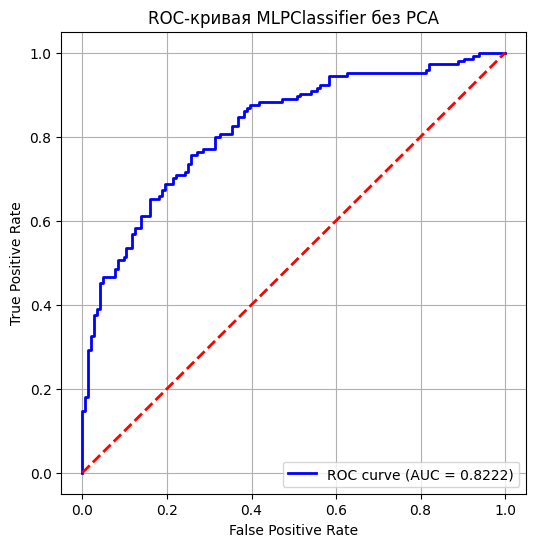

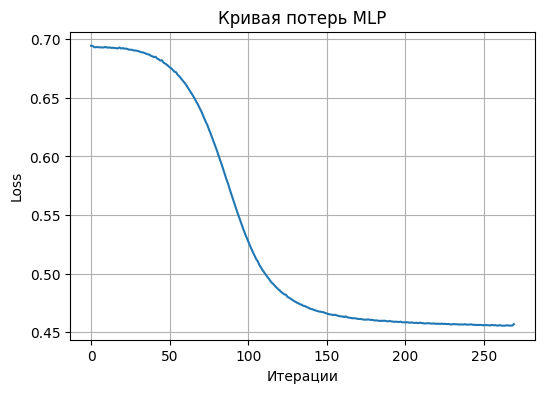

Визуализация для KPCA sigmoid

Accuracy: 0.5104
              precision    recall  f1-score   support

     Класс 0       0.71      0.03      0.07       144
     Класс 1       0.51      0.99      0.67       144

    accuracy                           0.51       288
   macro avg       0.61      0.51      0.37       288
weighted avg       0.61      0.51      0.37       288



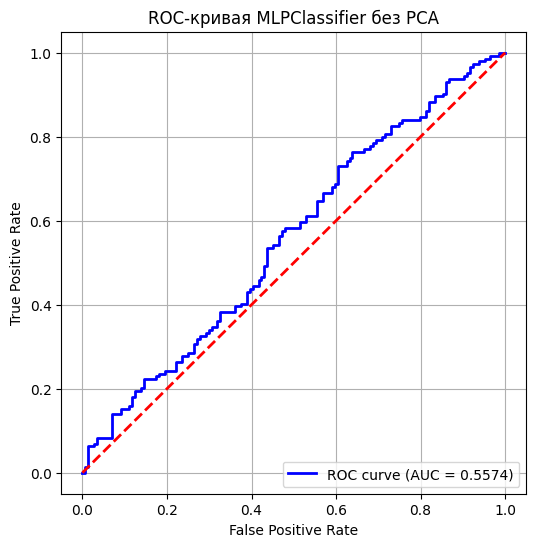

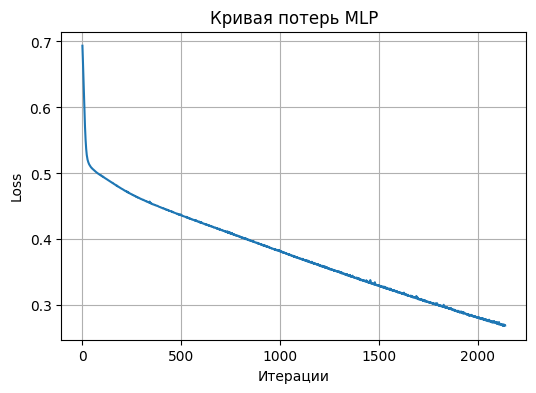

In [ ]:
for kernel, best_params in kpca_best_params.items():
    print(f"Визуализация для KPCA {kernel}")
    X_train_kpca, X_test_kpca = kpca_results[kernel]
    show_results(best_params, X_train_kpca, X_test_kpca, y_train, y_test)

## Часть 3. Сравнительный анализ

### Визуализация проекций

In [ ]:
def plot_projection_2D(X_proj, y, title):
    plt.figure(figsize=(6,5))
    plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y, cmap='coolwarm', s=20)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_projection_3D(X_proj, y, title):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        X_proj[:,0], X_proj[:,1], X_proj[:,2],
        c=y, cmap='coolwarm', s=20
    )

    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.set_title(title)

    # Легенда для классов
    legend1 = ax.legend(*scatter.legend_elements(), title="Class")
    ax.add_artist(legend1)

    plt.show()

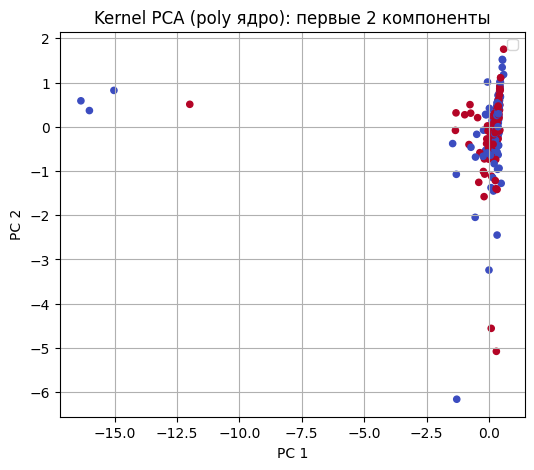

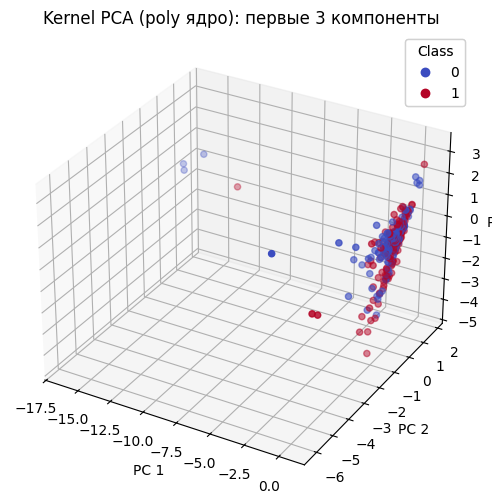

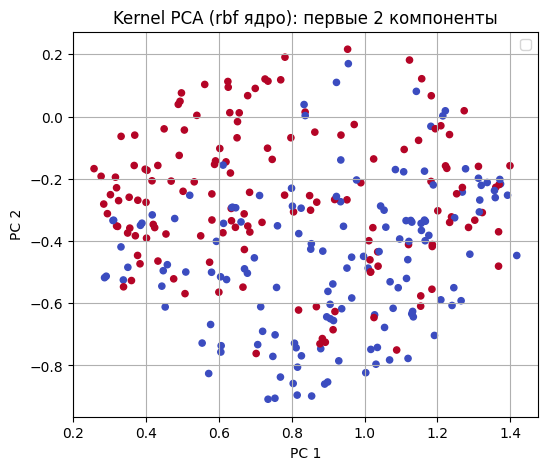

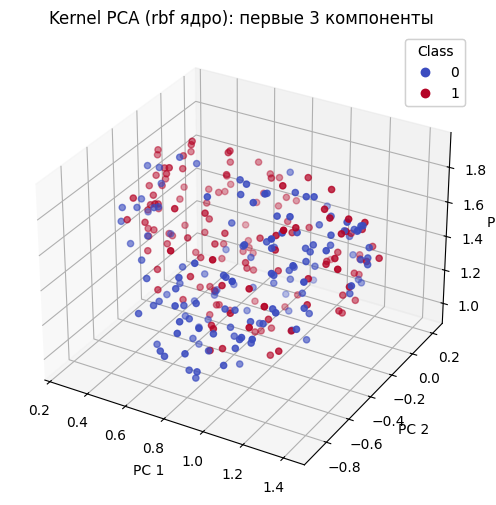

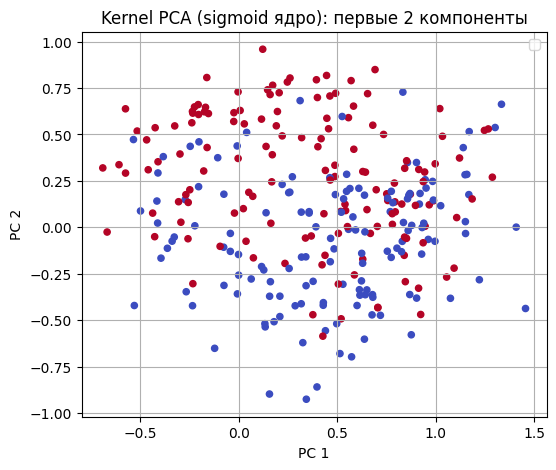

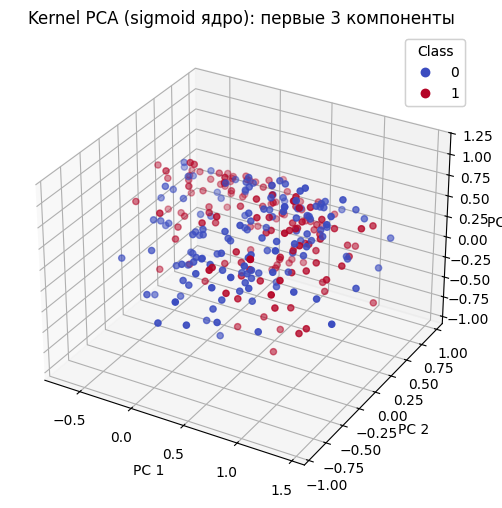

In [ ]:
for kernel, X_kpca in kpca_results.items():
    _, X_test_kpca = X_kpca
    plot_projection_2D(X_test_kpca, y_test.iloc[:, 0], f'Kernel PCA ({kernel} ядро): первые 2 компоненты')
    plot_projection_3D(X_test_kpca, y_test.iloc[:, 0], f'Kernel PCA ({kernel} ядро): первые 3 компоненты')

### Проверка линейной разделимости

In [ ]:
def check_linear_separability(X_proj, y):
    svm = SVC(kernel='linear')
    svm.fit(X_proj, y)
    acc = svm.score(X_proj, y)
    print(f'Линейная точность на проекциях (train): {acc*100:.2f}%')

print("Точность предсказания, используя SVC")
print("Base data:")
check_linear_separability(X_train, y_train)

print("PCA:")
X_train_PCA = pd.read_csv('/content/PCA_train.csv')
check_linear_separability(X_train_PCA, y_train)

for kernel, X_kpca in kpca_results.items():
    X_train_kpca, _ = X_kpca
    print(f"Kernel PCA ({kernel} ядро):")
    check_linear_separability(X_train_kpca, y_train)

Точность предсказания, используя SVC
Base data:
Линейная точность на проекциях (train): 75.22%
PCA:
Линейная точность на проекциях (train): 74.00%
Kernel PCA (poly ядро):
Линейная точность на проекциях (train): 76.00%
Kernel PCA (rbf ядро):
Линейная точность на проекциях (train): 76.87%
Kernel PCA (sigmoid ядро):
Линейная точность на проекциях (train): 75.22%
